<a href="https://colab.research.google.com/github/omkarsarde/DistributedAnalysisOfML/blob/main/GPU4G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Scaling
# Device: GPU
# Memory: 4GB

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fcec8279-6226-8ee5-1543-9c9bccfe67cd)


In [3]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow import keras
import time
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],  
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Load the dataset directly from tensorflow
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7QK2B2/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7QK2B2/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7QK2B2/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [6]:
# Split the dataset into train, test and validation sets
train_data = pcam['train']
test_data = pcam['test']
valid_data = pcam['validation']

In [7]:
# Preprocess the data
# data is in uint8, convert to float32
# also as we are using a off the shelf model, one hot encode the label
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [8]:
# Preprocess the split datasets using the preprocessing function we defined
train_data = train_data.map(convert_sample)
valid_data = valid_data.map(convert_sample)
test_data = test_data.map(convert_sample)

In [9]:
# Create batches for training testing and validation
# Set a buffer size for shuffling of training data
# Setting batch_size of 128 as batch size of 256 and above is causing overflow for training data
buffer_size = 1000
batch_size = 128
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [10]:
# STANDARD VGG16 Model
standard_Model = VGG16()
standard_Model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
standard_Model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [11]:
# Vgg16 based model We will Use
# THIS MODEL IS NOT PRETRAINED
new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [12]:
# Class to log times per epoch as 
# we will use TIME based comparison between hardware
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [13]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback = TimeHistory()
history = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/2048 [..............................] - ETA: 5:34 - loss: 0.6967 - acc: 0.5026WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0516s vs `on_train_batch_end` time: 0.0938s). Check your callbacks.


2048/2048 [==============================] - 433s 171ms/step - loss: 0.3940 - acc: 0.8229 - val_loss: 0.4870 - val_acc: 0.8111
Epoch 2/5
2048/2048 [==============================] - 436s 169ms/step - loss: 0.2226 - acc: 0.9122 - val_loss: 0.3576 - val_acc: 0.8694
Epoch 3/5
2048/2048 [==============================] - 428s 170ms/step - loss: 0.1591 - acc: 0.9408 - val_loss: 0.4308 - val_acc: 0.8397
Epoch 4/5
2048/2048 [==============================] - 426s 169ms/step - loss: 0.1276 - acc: 0.9540 - val_loss: 0.3017 - val_acc: 0.8834
Epoch 5/5
2048/2048 [==============================] - 439s 169ms/step - loss: 0.1052 - acc: 0.9631 - val_loss: 0.3152 - val_acc: 0.8823


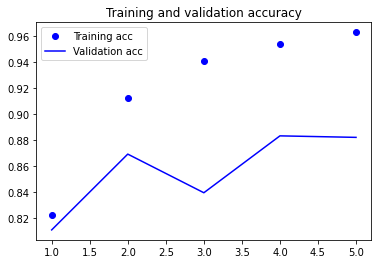

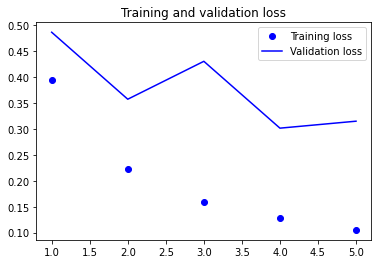

In [14]:
# Model Statistics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
# Time per epoch  in seconds
time_callback.times

[433.01518273353577,
 436.05906558036804,
 427.52801871299744,
 425.91223645210266,
 439.40364933013916]

In [16]:
# Model performance on Test Data
model.evaluate(test_data_batch, verbose=1)

128/128 [==============================] - 18s 135ms/step - loss: 0.5873 - acc: 0.8118


[0.5873085856437683, 0.811767578125]

In [17]:
# Model performance on Test Data
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.8118


In [18]:
# Retrain the model using a smaller batch size of 64
buffer_size = 1000
batch_size = 64
train_data_batch = train_data.batch(batch_size).shuffle(buffer_size).prefetch(2)
valid_data_batch = valid_data.batch(batch_size*2).prefetch(2)
test_data_batch = test_data.batch(batch_size*2).prefetch(2)

In [19]:
# Vgg16 based model We will Use
new_input = Input(shape=(96,96, 3))
model = VGG16(weights=None, input_tensor=new_input, classes=2)
model.compile(optimizer= Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [20]:
# Fit the model to the training data
# Restricting epochs to 5
time_callback64 = TimeHistory()
history64 = model.fit(train_data_batch, epochs = 5, callbacks=[ time_callback64], validation_data = valid_data_batch, verbose=1)

Epoch 1/5
   6/4096 [..............................] - ETA: 5:59 - loss: 0.6925 - acc: 0.5130WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0303s vs `on_train_batch_end` time: 0.0483s). Check your callbacks.


4096/4096 [==============================] - 426s 92ms/step - loss: 0.3952 - acc: 0.8116 - val_loss: 0.3838 - val_acc: 0.8328
Epoch 2/5
4096/4096 [==============================] - 422s 92ms/step - loss: 0.2097 - acc: 0.9180 - val_loss: 0.3243 - val_acc: 0.8706
Epoch 3/5
4096/4096 [==============================] - 424s 92ms/step - loss: 0.1543 - acc: 0.9435 - val_loss: 0.3518 - val_acc: 0.8638
Epoch 4/5
4096/4096 [==============================] - 424s 92ms/step - loss: 0.1282 - acc: 0.9538 - val_loss: 0.4623 - val_acc: 0.8364
Epoch 5/5
4096/4096 [==============================] - 425s 92ms/step - loss: 0.1085 - acc: 0.9614 - val_loss: 0.3716 - val_acc: 0.8663


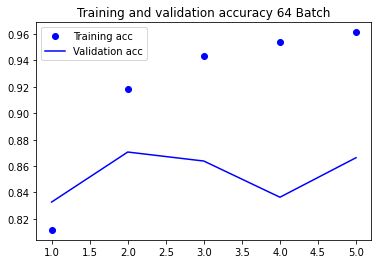

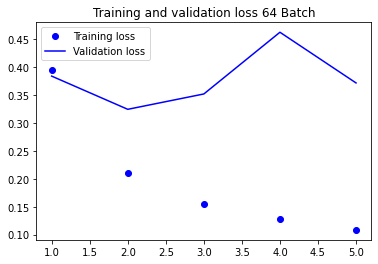

In [21]:

# Model Statistics
acc = history64.history['acc']
val_acc = history64.history['val_acc']
loss = history64.history['loss']
val_loss = history64.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy 64 Batch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss 64 Batch')
plt.legend()
plt.show()

In [22]:
# Time per epoch in seconds
time_callback64.times

[426.03668451309204,
 422.33493518829346,
 424.27787470817566,
 424.28548073768616,
 424.8746497631073]

In [23]:
# Model performance on Test Data
model.evaluate(test_data_batch, verbose=1)

256/256 [==============================] - 12s 47ms/step - loss: 0.5146 - acc: 0.8279


[0.5145723819732666, 0.827850341796875]

In [24]:
# Model performance on Test Data
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_data_batch, verbose=0)[1]))

Test set accuracy is 0.8279
